In [2]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.4 MB/s eta 0:00:00


In [1]:
# === 1. Import Library ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve, auc
import xgboost as xgb
import random
from xgboost import XGBClassifier
from deap import base, creator, tools, algorithms

In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)        # Seed untuk modul random
np.random.seed(RANDOM_SEED)     # Seed untuk NumPy

# Random Forest dengan random_state tetap
rf_model = RandomForestClassifier(random_state=RANDOM_SEED)

# XGBoost dengan random_state tetap
xgb_model = XGBClassifier(random_state=RANDOM_SEED)

In [3]:
# === 2. Load Dataset ===
df = pd.read_csv("Lung Cancer Dataset.csv")
df = df.sort_values(by="AGE", ascending=True).reset_index(drop=True)
df['PULMONARY_DISEASE'] = df['PULMONARY_DISEASE'].map({'YES': 1, 'NO': 0})  # Encoding target variable

In [4]:
# Pisahkan fitur dan target
X = df.drop(columns=['PULMONARY_DISEASE'])
y = df['PULMONARY_DISEASE']

In [5]:
# Konversi fitur kategori ke numerik (jika ada)
X = pd.get_dummies(X)

In [6]:
# Split data
# Membagi data dengan random_state agar hasil tetap sama
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y, shuffle=True
)

In [7]:
# === 3. Parameter Genetic Algorithm ===
POPULATION_SIZE = 20  # Ukuran populasi
N_GENERATIONS = 50  # Jumlah iterasi generasi
MUTATION_RATE = 0.2  # Peluang mutasi

In [8]:
# Inisialisasi GA
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [9]:
toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [10]:
# === 4. Genetic Algorithm for Feature Selection (Random Forest) ===
def evaluate_rf(individual):
    selected_features = [col for i, col in enumerate(X.columns) if individual[i] == 1]
    if len(selected_features) == 0:
        return 0,
    X_selected = X[selected_features]
    X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = accuracy_score(y_test_sel, model.fit(X_train_sel, y_train_sel).predict(X_test_sel))
    return scores,

toolbox.register("evaluate", evaluate_rf)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=MUTATION_RATE)
toolbox.register("select", tools.selTournament, tournsize=3)

In [11]:
# Simpan nilai fitness terbaik tiap generasi
best_fitness_per_generation = []

In [12]:
# Jalankan GA untuk RF
population = toolbox.population(n=POPULATION_SIZE)
hof = tools.HallOfFame(1)

# Menjalankan GA dalam satu kali pemanggilan untuk semua generasi
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("avg", np.mean)

print(f"Running Genetic Algorithm for {N_GENERATIONS} generations...\n")

# Jalankan GA satu kali untuk semua generasi
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2,
                                          ngen=N_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# Simpan nilai fitness terbaik dari setiap generasi
best_fitness_per_generation = logbook.select("max")

# Pastikan bahwa GA berhasil menemukan individu terbaik
if len(hof) > 0:
    best_features_rf = [col for i, col in enumerate(X.columns) if hof[0][i] == 1]
    print("\nFitur Terbaik yang Dipilih oleh GA untuk Random Forest:")
    print(best_features_rf)
else:
    print("⚠️ GA tidak menemukan individu terbaik. Periksa kembali parameter GA.")
    best_features_rf = []

Running Genetic Algorithm for 50 generations...

gen	nevals	max  	min  	avg   
0  	20    	0.868	0.533	0.7098
1  	11    	0.868	0.666	0.784 
2  	17    	0.915	0.704	0.8199
3  	9     	0.917	0.699	0.84565
4  	11    	0.919	0.711	0.87015
5  	12    	0.922	0.758	0.8895 
6  	13    	0.922	0.799	0.90555
7  	11    	0.922	0.664	0.8943 
8  	8     	0.922	0.833	0.91315
9  	9     	0.922	0.832	0.91665
10 	11    	0.922	0.706	0.88285
11 	15    	0.922	0.767	0.9048 
12 	11    	0.922	0.838	0.91575
13 	10    	0.922	0.711	0.89515
14 	11    	0.922	0.807	0.90865
15 	10    	0.922	0.757	0.883  
16 	12    	0.922	0.675	0.87025
17 	10    	0.922	0.677	0.8763 
18 	13    	0.922	0.683	0.891  
19 	11    	0.922	0.733	0.89555
20 	7     	0.922	0.855	0.91545
21 	14    	0.922	0.723	0.9092 
22 	11    	0.922	0.666	0.8875 
23 	11    	0.922	0.676	0.88115
24 	4     	0.922	0.637	0.8991 
25 	10    	0.922	0.73 	0.8959 
26 	17    	0.922	0.789	0.90085
27 	10    	0.922	0.741	0.907  
28 	5     	0.922	0.812	0.91185
29 	11    	0.922	0.687	0.

In [13]:
# === 5. Genetic Algorithm for Feature Selection (XGBoost) ===
def evaluate_xgb(individual):
    selected_features = [col for i, col in enumerate(X.columns) if individual[i] == 1]
    if len(selected_features) == 0:
        return 0,
    X_selected = X[selected_features]
    X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    model = XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss")
    scores = accuracy_score(y_test_sel, model.fit(X_train_sel, y_train_sel).predict(X_test_sel))
    return scores,

toolbox.register("evaluate", evaluate_xgb)

In [14]:
# Simpan nilai fitness terbaik tiap generasi untuk XGBoost
best_fitness_per_generation_xgb = []

In [15]:
# Jalankan GA untuk XGBoost
population = toolbox.population(n=POPULATION_SIZE)
hof = tools.HallOfFame(1)

# Menjalankan GA dalam satu kali pemanggilan untuk semua generasi
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("avg", np.mean)

print(f"Running Genetic Algorithm for XGBoost with {N_GENERATIONS} generations...\n")

# Jalankan GA satu kali untuk semua generasi
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2,
                                          ngen=N_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# Simpan nilai fitness terbaik dari setiap generasi
#best_fitness_per_generation_xgb = logbook.select("max")
best_fitness_per_generation_xgb = logbook.select("max")[1:]  # Hilangkan nilai generasi 0
# Pastikan bahwa GA berhasil menemukan individu terbaik
if len(hof) > 0:
    best_features_xgb = [col for i, col in enumerate(X.columns) if hof[0][i] == 1]
    print("\nFitur Terbaik yang Dipilih oleh GA untuk XGBoost:")
    print(best_features_xgb)
else:
    print("⚠️ GA tidak menemukan individu terbaik untuk XGBoost. Periksa kembali parameter GA.")
    best_features_xgb = []

Running Genetic Algorithm for XGBoost with 50 generations...

gen	nevals	max  	min 	avg    
0  	20    	0.865	0.58	0.70865
1  	10    	0.875	0.677	0.8033 
2  	12    	0.907	0.673	0.83925
3  	12    	0.912	0.695	0.86355
4  	14    	0.912	0.639	0.84025
5  	12    	0.912	0.703	0.8574 
6  	13    	0.912	0.696	0.8682 
7  	12    	0.912	0.747	0.88485
8  	11    	0.912	0.61 	0.8771 
9  	15    	0.912	0.817	0.90425
10 	13    	0.912	0.687	0.8889 
11 	12    	0.912	0.793	0.89605
12 	11    	0.912	0.753	0.87725
13 	7     	0.912	0.686	0.88785
14 	4     	0.912	0.912	0.912  
15 	12    	0.912	0.784	0.8993 
16 	12    	0.912	0.665	0.8865 
17 	12    	0.912	0.706	0.8945 
18 	11    	0.912	0.704	0.8939 
19 	15    	0.912	0.711	0.8926 
20 	11    	0.912	0.733	0.88575
21 	13    	0.912	0.733	0.89865
22 	12    	0.912	0.723	0.88215
23 	8     	0.912	0.829	0.90385
24 	10    	0.912	0.683	0.87655
25 	15    	0.912	0.607	0.88095
26 	8     	0.912	0.85 	0.9065 
27 	8     	0.912	0.861	0.90925
28 	17    	0.912	0.684	0.864  
29 	11    

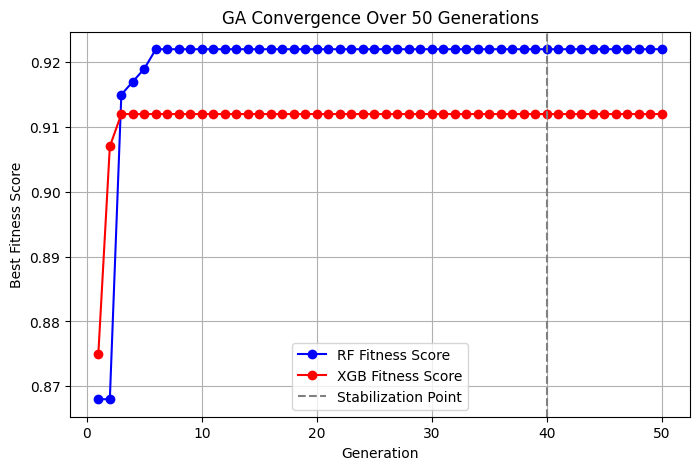

In [16]:
# === 6. Visualisasi Konvergensi GA ===
plt.figure(figsize=(8, 5))

# Pastikan jumlah data cocok dengan jumlah generasi
generations = list(range(1, N_GENERATIONS+1))  # Mulai dari 1 agar generasi 0 tidak ikut

# Plot konvergensi untuk Random Forest
plt.plot(generations, best_fitness_per_generation[:N_GENERATIONS],
         marker='o', linestyle='-', color='b', label='RF Fitness Score')

# Plot konvergensi untuk XGBoost
plt.plot(generations, best_fitness_per_generation_xgb[:N_GENERATIONS],
         marker='o', linestyle='-', color='r', label='XGB Fitness Score')

# Garis vertikal sebagai tanda stabilisasi
plt.axvline(x=40, linestyle='--', color='gray', label='Stabilization Point')

# Judul dan label
plt.title("GA Convergence Over 50 Generations")
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")
plt.legend()
plt.grid()

# Tampilkan grafik
plt.show()

In [17]:
# === 7. Evaluasi Model ===
def evaluate_model(model, X_train, X_test, y_train, y_test, desc):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    return [desc, acc, precision, recall, f1, auc]



In [18]:
results=[]
# Evaluasi Random Forest
results.append(evaluate_model(RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED), X_train, X_test, y_train, y_test, "Random Forest Sebelum GA"))
results.append(evaluate_model(RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED), X_train[best_features_rf], X_test[best_features_rf], y_train, y_test, "Random Forest Setelah GA"))
# Evaluasi XGBoost
results.append(evaluate_model(XGBClassifier(n_estimators=100, random_state=RANDOM_SEED, eval_metric="logloss"), X_train, X_test, y_train, y_test, "XGBoost Sebelum GA"))
results.append(evaluate_model(XGBClassifier(n_estimators=100, random_state=RANDOM_SEED, eval_metric="logloss"), X_train[best_features_xgb], X_test[best_features_xgb], y_train, y_test, "XGBoost Setelah GA"))


In [19]:
# Menampilkan hasil evaluasi dalam bentuk tabel
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC-ROC"])
print(df_results)

                      Model  Accuracy  Precision    Recall  F1-score   AUC-ROC
0  Random Forest Sebelum GA     0.920   0.909774  0.891892  0.900744  0.915592
1  Random Forest Setelah GA     0.921   0.910000  0.894349  0.902107  0.916820
2        XGBoost Sebelum GA     0.908   0.890819  0.882064  0.886420  0.903932
3        XGBoost Setelah GA     0.910   0.885645  0.894349  0.889976  0.907545


In [20]:
# === 4. Evaluasi Model ===
def evaluate_model(model, X_train, X_test, y_train, y_test, desc):
    """ Fungsi untuk mengevaluasi model dengan metrik akurasi, presisi, recall, F1-score, dan AUC-ROC """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]  # Probabilitas kelas positif untuk AUC-ROC
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_probs)
    return [desc, acc, precision, recall, f1, auc_roc]

# List untuk menyimpan hasil evaluasi
results = []

# Evaluasi Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
results.append(evaluate_model(rf_model, X_train[best_features_rf], X_test[best_features_rf], y_train, y_test, "Random Forest"))

# Evaluasi XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=RANDOM_SEED, eval_metric="logloss")
results.append(evaluate_model(xgb_model, X_train[best_features_xgb], X_test[best_features_xgb], y_train, y_test, "XGBoost"))

# Menampilkan hasil evaluasi dalam bentuk tabel
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC-ROC"])
print("\nHasil Evaluasi Model:")
print(df_results)



Hasil Evaluasi Model:
           Model  Accuracy  Precision    Recall  F1-score   AUC-ROC
0  Random Forest     0.921   0.910000  0.894349  0.902107  0.924040
1        XGBoost     0.910   0.885645  0.894349  0.889976  0.921836


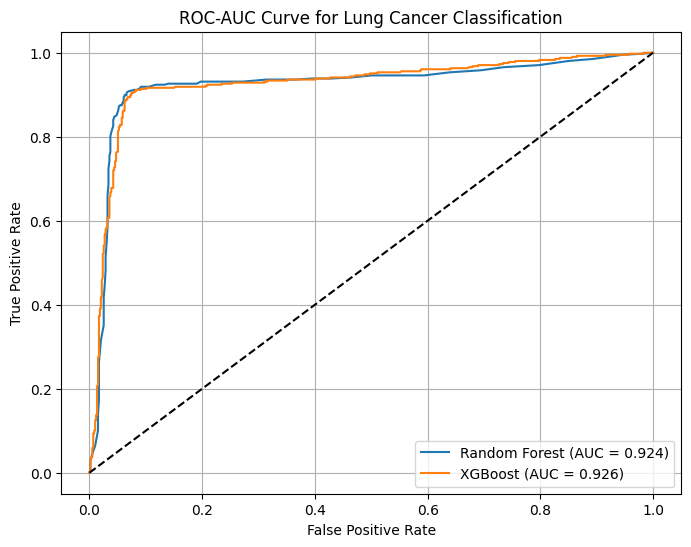

In [35]:

# === 5. Visualisasi Kurva ROC-AUC ===
plt.figure(figsize=(8, 6))

def plot_roc_auc(model, X_test, y_test, model_name):
    """ Fungsi untuk menampilkan kurva ROC-AUC """
    y_probs = model.predict_proba(X_test)[:, 1]  # Probabilitas kelas positif
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")

# Plot ROC-AUC untuk RF dan XGB
plot_roc_auc(rf_model, X_test[best_features_rf], y_test, "Random Forest")
plot_roc_auc(xgb_model, X_test[best_features_xgb], y_test, "XGBoost")

# Menambahkan garis diagonal sebagai referensi
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Lung Cancer Classification")
plt.legend(loc="lower right")
plt.grid()
plt.show()